In [1]:
%pylab inline
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqmodels import QLF_McGreer_2013

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,u'absolute mag')

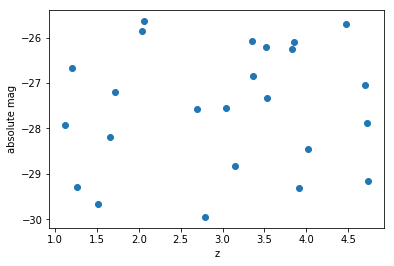

In [2]:
# set up a luminosity-redshift grid
M = AbsMagVar(UniformSampler(-30,-25),restWave=1450)
z = RedshiftVar(UniformSampler(1,5))
MzGrid = QsoSimGrid([M,z],(4,3),2)
scatter(MzGrid.z,MzGrid.absMag,)
xlabel('z')
ylabel('absolute mag')

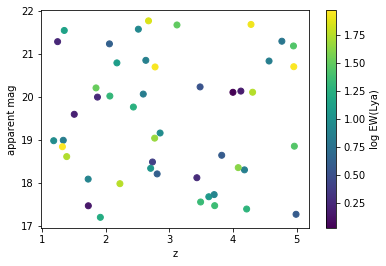

In [3]:
# set up a flux-redshift grid with Lya EW as a third dimension
m = AppMagVar(UniformSampler(17,22),'SDSS-i')
lya = GaussianLineEqWidthVar(UniformSampler(0,2),'LyaEW',1215.67,10.)
mzlyaGrid = QsoSimGrid([m,z,lya],(4,3,2),2)
scatter(mzlyaGrid.z,mzlyaGrid.appMag,c=mzlyaGrid.LyaEW)
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('log EW(Lya)')

In [4]:
# Generate m,z points by sampling from a model QLF
cosmo = QLF_McGreer_2013.cosmo
kcorr = sqbase.ContinuumKCorr('SDSS-i',1450)
qlfGrid =  generateQlfPoints(QLF_McGreer_2013,
                             (17,22),(4.5,5.3),kcorr,
                             skyArea=100)

integration returned  43  objects


Text(0,0.5,u'apparent mag')

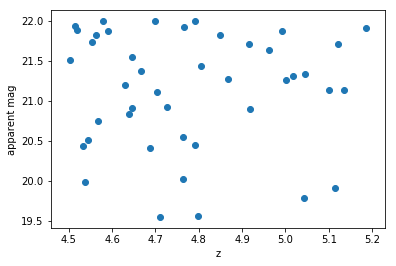

In [5]:
scatter(qlfGrid.z,qlfGrid.appMag)
xlabel('z')
ylabel('apparent mag')

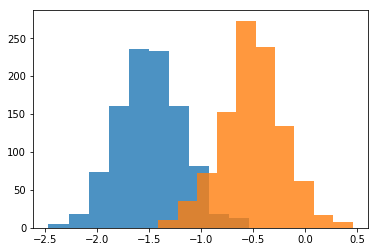

In [6]:
# test the canonical values for power law continuum slopes in FUV/NUV
contVar = BrokenPowerLawContinuumVar([GaussianSampler(-1.5,0.3),GaussianSampler(-0.5,0.3)],[1215.])
contVals = contVar(1000)
_ = hist(contVals[:,0],alpha=0.8)
_ = hist(contVals[:,1],alpha=0.8)

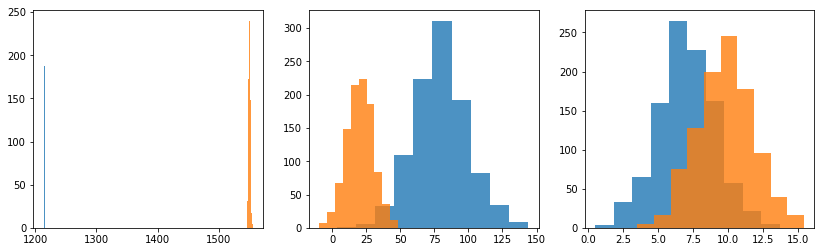

In [7]:
# Add gaussian emission lines
g = GaussianSampler
lya = [g(1215.7,0.5),g(80,20),g(7,2)]
civ = [g(1550.0,1.5),g(20,10),g(10,2)]
emLinesVar = GaussianEmissionLinesTemplateVar([lya,civ])
emLinesVals = emLinesVar(1000)
figure(figsize=(14,4))
for k in range(3):
    subplot(1,3,k+1)
    for j in range(2):
        hist(emLinesVals[:,j,k],alpha=0.8)

In [8]:
# add gaussian lines to the qlf grid
qlfGrid.addVar(emLinesVar)
print qlfGrid

    appMag        absMag           z               emLines [2,3]         
------------- -------------- ------------- ------------------------------
19.7908266291 -26.7779194928 5.04320570725 1215.81857443 .. 7.47904760629
 21.922703573 -24.5263181599 4.76524836302 1216.11684848 .. 9.18815829268
20.4412185229 -25.9017261182 4.53302069017 1215.58275717 .. 7.59416720719
20.0259322337  -26.422164589 4.76316776494 1216.40621171 .. 11.1528311888
20.9009110541 -25.6153369968 4.91918708524 1215.62340964 .. 9.72779686534
21.6441363322 -24.8899235783 4.96088485587 1216.39503368 .. 10.2248630119
21.8317998929 -24.5249075917 4.56243473333  1216.1255422 .. 6.52989006223
21.2771621808 -25.2168035525 4.86756581988 1215.19612085 .. 10.5758914789
21.3805928484 -25.0242869214 4.66705657111 1215.46237774 .. 5.73714662249
21.8758200857 -24.6713477074 4.99181884345 1216.04751789 .. 9.65713429789
          ...            ...           ...                            ...
21.1405859314 -25.4520658956 5.1008150

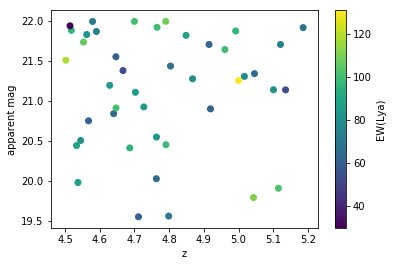

In [9]:
scatter(qlfGrid.z,qlfGrid.appMag,c=qlfGrid.emLines[:,0,1])
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('EW(Lya)')

In [10]:
# Now use the BOSS DR9 emission line template, including the Baldwin Effect
lineTemplate = generateBEffEmissionLines(qlfGrid.absMag)
lines = lineTemplate()
lines.shape

(43, 62, 3)

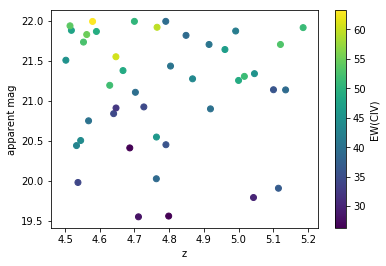

In [11]:
scatter(qlfGrid.z,qlfGrid.appMag,c=lines[:,13,1])
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('EW(CIV)')

In [12]:
vdblines = generateVdBCompositeEmLines(minEW=0)
vdblines = vdblines(qlfGrid.nObj)

using the following lines from VdB template:  Ly{epsilon},CIII,Ly{beta},ArI,FeIII,CIII*,Ly{alpha},NV,SiII,OI,CII,SiIV,CIV,HeII,OIII],NIV,NIII],FeII,SiII,AlIII,SiIII],CIII],FeIII,FeIII,FeII,FeII,FeII,CII],[NeIV],[OII],FeII,AlII],MgII,FeII,OIII,HeI,FeI,FeII,[NeV],[NeV],FeII,[FeVII],[OII],[FeVII],FeII,FeII,[NeIII],HeI,[NeIII],[FeV],H{delta},FeII,FeII,[FeII],[FeII],H{gamma},[OIII],FeII,FeII,HeII,H{beta},FeII,[OIII],[OIII],[FeVII],[FeVI],[NI],[FeVII],FeII,[FeXIV],[ClIII],[FeVII],HeI,[FeVII],[OI],[OI],[NII],H{alpha},[NII],[SII],[SII],HeI,[ArIII],[OII],[NiIII]


In [13]:
wave = arange(3000,1e4,0.5)
z = 2.0
def quick_spec(emlines):
    lineWave,eqWidth,sigma = emlines.T * (1+z)
    spec = np.zeros_like(wave)
    A = eqWidth/(np.sqrt(2*np.pi)*sigma)
    twosig2 = 2*sigma**2
    nsig = np.sqrt(-2*np.log(1e-3/A))
    nsig = (nsig*np.array([[-1.],[1]])).T
    for i in xrange(lineWave.shape[0]):
        i1,i2 = np.searchsorted(wave,lineWave[i]+nsig[i]*sigma[i])
        if i2 != i1:
            lineprofile = A[i]*np.exp(-(wave[i1:i2]-lineWave[i])**2
                                       / twosig2[i])
            spec[i1:i2] += lineprofile
    return spec

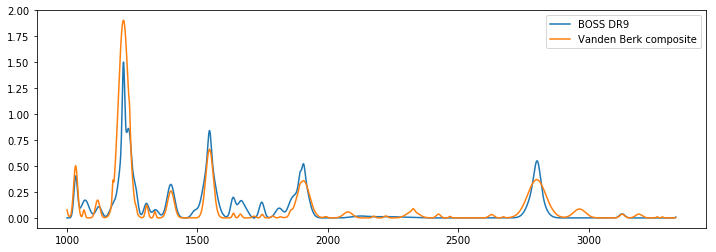

In [14]:
figure(figsize=(12,4))
plot(wave/(1+z),quick_spec(lines[0]),label='BOSS DR9')
plot(wave/(1+z),quick_spec(vdblines[0]),label='Vanden Berk composite')
legend()